In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb


In [0]:
from sklearn.datasets import fetch_openml

In [0]:
mnist = fetch_openml('mnist_784', version = 1)

In [0]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [0]:
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1, 28, 28))],0)
y_vec = mnist.target.astype(np.uint8)

_gray2rgb로 black / white channel을 rgb 채널로 바꿔줌. 그래서 3채널로 넓어짐_  
_그리고 784로 flatten되어있는 데이터를 28x28형태로, 결과는 아래와 같음_

In [0]:
X_vec.shape, mnist.data.shape 

((70000, 28, 28, 3), (70000, 784))

In [0]:
X_vec.dtype

dtype('float64')

In [0]:
X_vec[0].astype('uint8').dtype

dtype('uint8')

_넘파이 데이터 타입을 uint8 형태로 바꾸어 줘야만 원하는 이미지를 얻을 수 있음 이유는 모르겠다._  
_아래는 자료형을 바꾸어주었을때, 그리고 바꾸어 주지 않았을때를 비교한 이미지_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Digit: 5, dtype = uint8')

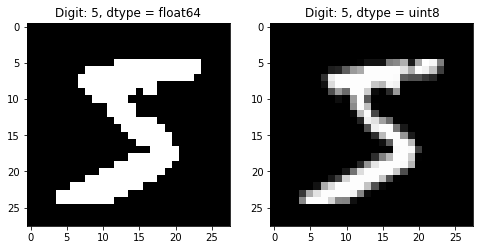

In [0]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))

ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}, dtype = float64'.format(y_vec[0]))

ax2.imshow(X_vec[0].astype('uint8'), interpolation = 'none')
ax2.set_title('Digit: {}, dtype = uint8'.format(y_vec[0]))

Text(0.5, 1.0, 'Digit: 5')

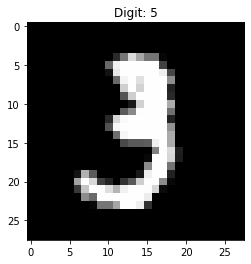

In [0]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[10].astype('uint8'), interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

### Pipeline 구축하기

_정의한 Class PipeStep은 사이킷런의 fit, transform을 함수로 가지는 클래스_  
_위 클래스를 이용해서 makegray-step에 imglist를 rgb -> gray적용_,  
_또한 flattenstep에 img데이터에 ravel()을 적용(flatten)_  
_마지막으로 simple rf pipeline으로 위 과정들을 연결해주고 default RandomForestClassfiier까지 연결_

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
    def fit(self,*args):
        return self
    def transform(self, X):
        return self._step_func(X)  ##sklearn fit transform을 위한 함수
    
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list]) # rgb데이터를 gray데이터로
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list]) ##데이터를 평평하게 만들어줌

simple_rf_pipleine = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('RF', RandomForestClassifier())
])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                   train_size = 0.55)

In [0]:
simple_rf_pipleine.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x7faef4d0b390>),
                ('Flatten Image', <__main__.PipeStep object at 0x7faef4d0ba90>),
                ('RF',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=F

--------  
________

pypi 의 lime https://github.com/marcotcr/lime

In [0]:
!pip install lime

In [0]:
import lime

In [0]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [0]:
explainer = lime_image.LimeImageExplainer(verbose = True)
segmenter = SegmentationAlgorithm('quickshift', kernel_size = 1, max_dist = 200, ratio = 0.2)

In [0]:
explanation = explainer.explain_instance(X_test[0].astype('uint8'),
                                        classifier_fn = simple_rf_pipleine.predict_proba,
                                        top_labels = 10, hide_color = 0, num_samples = 10000, segmentation_fn = segmenter)

Intercept 0.0
Prediction_local [0.]
Right: 0.0
Intercept 0.019999999999999997
Prediction_local [0.02]
Right: 0.02
Intercept 0.010011476568945809
Prediction_local [0.02999178]
Right: 0.03
Intercept 0.020011476568945807
Prediction_local [0.03999178]
Right: 0.04
Intercept 0.039999999999999994
Prediction_local [0.04]
Right: 0.04
Intercept 0.010017214853418669
Prediction_local [0.03998766]
Right: 0.04
Intercept 0.07999426171552709
Prediction_local [0.07000411]
Right: 0.07
Intercept 0.09998852343105417
Prediction_local [0.08000822]
Right: 0.08
Intercept 0.3099426171552709
Prediction_local [0.21004112]
Right: 0.21
Intercept 0.41003442970683723
Prediction_local [0.46997533]
Right: 0.47


Text(0.5, 1.0, 'Positive/Negative Regions for 7')

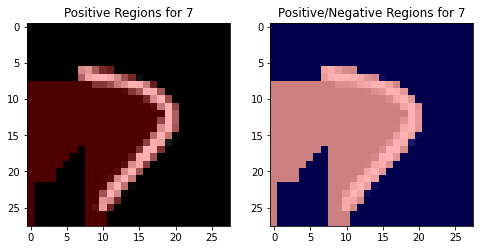

In [0]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

좌측그림의 붉은색 부분은 7으로 판단하는데 Classifier가 긍정적으로 평가한 부분이다.  
우측그림의 붉은색(분홍색) 부분은 7로 판단하는데 Classifier가 긍정적으로 평가한 부분이고 녹색 부분은 7로 분류하는데 부정적 요인이 된 데이터들이다.

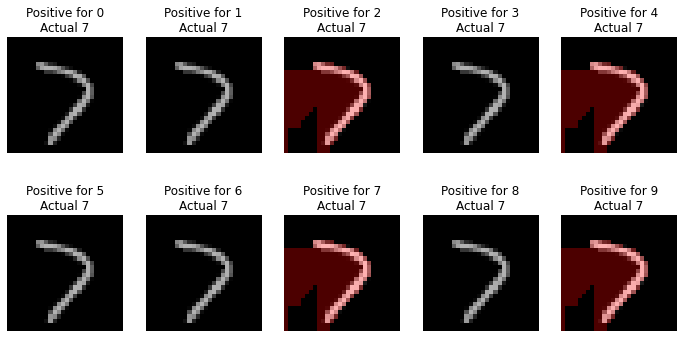

In [0]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0].astype('uint8'), bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

_Lime 알고리즘을 통해 각 레이블로 분류하는데 긍정적인 요인을 끼친 부분을 시각화 한그림이다,_  
_7을 0,1,3,6,8을 분류할 때는 전혀 영향이 없다. 반면, 2,4,9 로 분류할때는 일부분 Lime 알고리즘이 반응한 것을 알 수 있다._  
_이때 RF 알고리즘은 7으로 제대로 분류했는데 이미지를 보았을때도 7로 분류할때 가장 긍정적인 부분이 크게 나타났다고 볼 수 있다._


__잘못 분류된 레이블에 대해 Lime으로 평가해보자__

In [0]:
y_test

array([7, 3, 6, ..., 0, 7, 9], dtype=uint8)

In [0]:
pipe_pred_test = simple_rf_pipleine.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #30709 where the label was 5 and the pipeline predicted 6


실제 label은 5이지만 pipeline(rf_classifier)의 예측은 3인 경우 lime 알고리즘은 아래와 같은 이미지를 나타냈다.

In [0]:
explanation = explainer.explain_instance(X_test[wrong_idx].astype('uint8'), 
                                         classifier_fn = simple_rf_pipleine.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

Intercept 0.003733445977650485
Prediction_local [0.0116061]
Right: 0.01
Intercept 0.031194033442765876
Prediction_local [0.04482233]
Right: 0.04
Intercept 0.05119393840886477
Prediction_local [0.0648222]
Right: 0.06
Intercept 0.017485520324154256
Prediction_local [0.06319975]
Right: 0.06
Intercept 0.08134518902431648
Prediction_local [0.06196118]
Right: 0.07
Intercept 0.28005227945050526
Prediction_local [0.08720594]
Right: 0.1
Intercept 0.03868585825710578
Prediction_local [0.10801806]
Right: 0.1
Intercept 0.4023723274186115
Prediction_local [0.12689667]
Right: 0.13
Intercept 0.002663031457166662
Prediction_local [0.19669994]
Right: 0.2
Intercept 0.09127437623885917
Prediction_local [0.23476783]
Right: 0.23


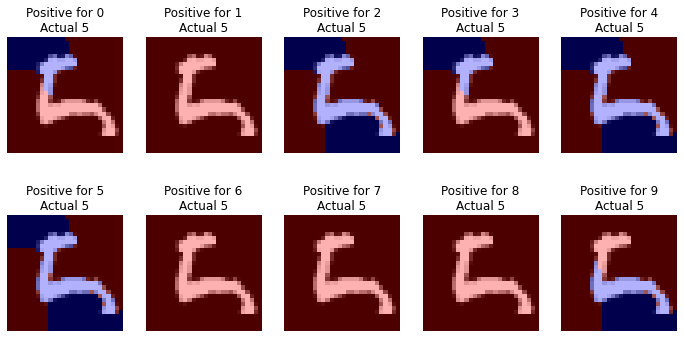

In [0]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 2), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')